# Forecasting crime in NYC

In [50]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm
from datetime import datetime, timedelta
from pmdarima import auto_arima

path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

In [51]:
# opening dataset
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [52]:
# transforming dataframe into timeseries
def into_timeseries(df):
    df = df.groupby('date').agg(count=('precinct','count')).reset_index()
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    return df
    
crime_ts = into_timeseries(crime)

# Weekly seasonality
- The approach will be to predict crimes by week.

In [53]:
weekly = crime_ts.resample('M').mean()
weekly.drop(weekly.tail(1).index, inplace=True)

## Calculate stationarity
- Using ADFuller test

ADF Statistic: -0.5180352574452919
p-value: 0.8884487260869216
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


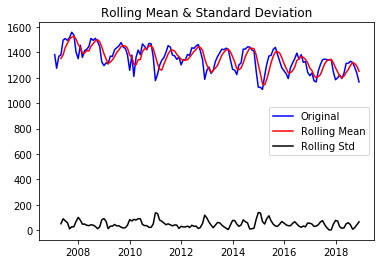

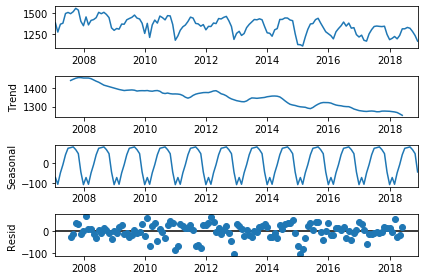

In [54]:
def get_stationarity(timeseries, window=4):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    decomposition = seasonal_decompose(timeseries, model='additive')
    decomposition.plot();
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['count'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

get_stationarity(weekly)

- there is a strong seasonal component which is good!
- there is also a non-significant trend, but we might be interested in removing it. 

# Calculate autocorrelations to determine parameters of ARIMA

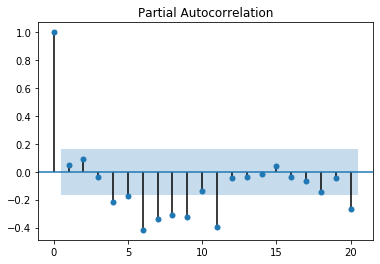

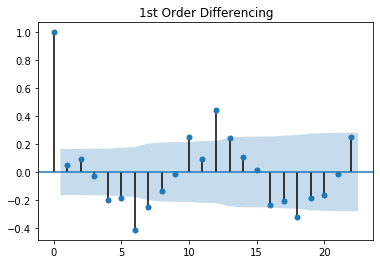

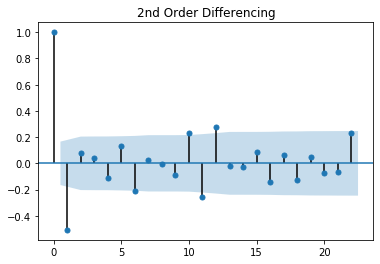

In [67]:
def auto_correlation(timeseries):

    fig = plot_pacf(timeseries.diff().dropna(), lags=20, title='Partial Autocorrelation')
    fig = plot_acf(timeseries.diff().dropna(), title="1st Order Differencing")
    fig = plot_acf(timeseries.diff().diff().dropna(), title="2nd Order Differencing")
    
auto_correlation(weekly)

# Create ARIMA model

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                  141
Model:                 ARIMA(6, 1, 1)   Log Likelihood                -734.539
Method:                       css-mle   S.D. of innovations             43.061
Date:                Mon, 16 Mar 2020   AIC                           1487.077
Time:                        09:18:51   BIC                           1513.616
Sample:                    02-28-2007   HQIC                          1497.862
                         - 10-31-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.3270      0.084    -15.852      0.000      -1.491      -1.163
ar.L1.D.count     0.4886      0.079      6.147      0.000       0.333       0.644
ar.L2.D.count     0.0194      0.091      0.214      0.831      -0.158       0.197
ar.L3.D.count    -0.0630      0.090     -0.701      0.483      -0.239       0.113
ar.L4.D.count    -0.1627      0.089     -1.818      0.069      -0.338       0.013
ar.L5.D.count    -0.0528      0.091     -0.581      0.561      -0.231       0.125
ar.L6.D.count    -0.3385      0.080     -4.226      0.000      -0.495      -0.181
ma.L1.D.count    -1.0000      0.023    -42.707      0.000      -1.046      -0.954
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8953           -0.5135j            1.0321           -0.0829
AR.2            0.8953           +0.5135j            1.0321            0.0829
AR.3           -1.0735           -0.6969j            1.2799           -0.4084
AR.4           -1.0735           +0.6969j            1.2799            0.4084
AR.5            0.1002           -1.2973j            1.3012           -0.2377
AR.6            0.1002           +1.2973j            1.3012            0.2377
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

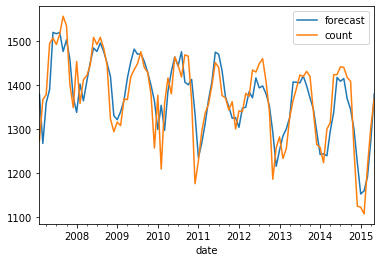

In [100]:
model = ARIMA(weekly, order=(6,1,1))
results = model.fit(disp=0)

results.plot_predict(1,100);
results.summary()

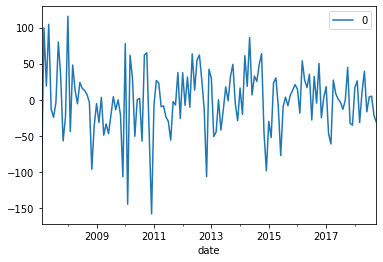

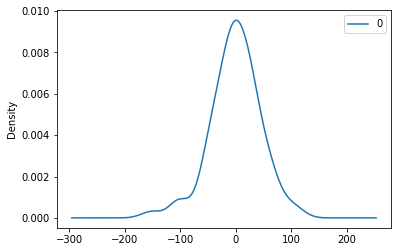

                0
count  141.000000
mean    -0.774275
std     45.232052
min   -158.362146
25%    -24.995659
50%     -0.165556
75%     27.165743
max    115.701905


In [92]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Testing ARIMA model on 75-25% split

In [141]:
X = weekly.values
size = int(len(X) * 0.75)   # Split percentage

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(6,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


100%|██████████| 35/35 [00:25<00:00,  1.39it/s]


# Calculating MAE.

Test MAE: 23.559


1.8615214670144467

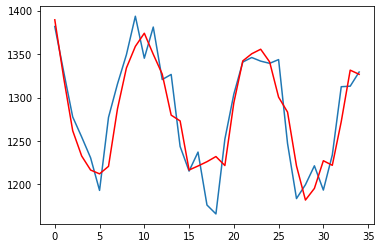

In [143]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red');

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test, predictions)

# ARIMA for one precinct

In [159]:
example = crime.loc[(crime.precinct == 75)]

# transforming dataframe into timeseries
example_ts = example.groupby('date').agg(count=('precinct','count')).reset_index()
example_ts = example_ts.set_index('date')
example_ts.index = pd.to_datetime(example_ts.index)

ADF Statistic: -0.7903784146129832
p-value: 0.8219320103520575
Critical Values:
	1%: -3.480118600110386
	5%: -2.8833618426136196
	10%: -2.578407034974382


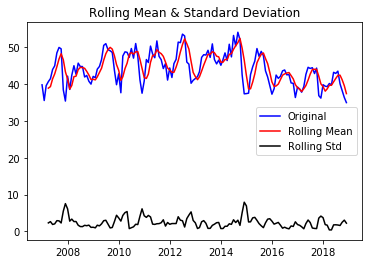

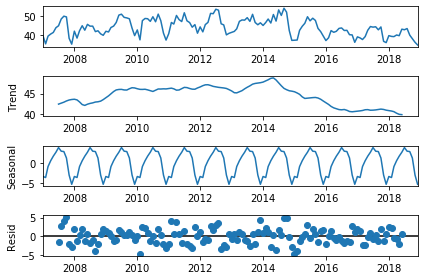

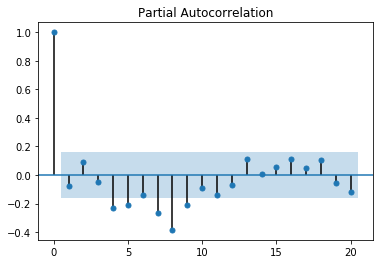

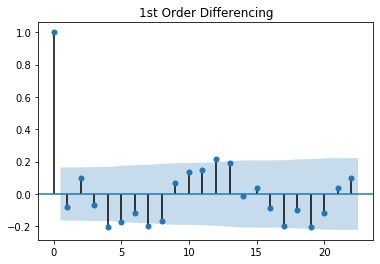

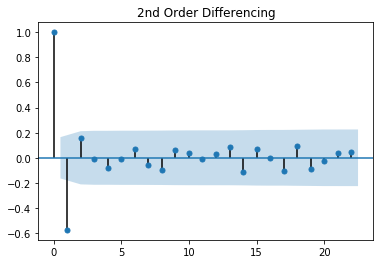

In [160]:
example_sample = example_ts.resample('MS').mean()
weekly.drop(weekly.tail(1).index, inplace=True)
get_stationarity(example_sample)
auto_correlation(example_sample)

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                  143
Model:                 ARIMA(8, 1, 1)   Log Likelihood                -336.335
Method:                       css-mle   S.D. of innovations              2.515
Date:                Mon, 16 Mar 2020   AIC                            694.671
Time:                        10:11:32   BIC                            727.262
Sample:                    02-01-2007   HQIC                           707.914
                         - 12-01-2018                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0258      0.044     -0.583      0.560      -0.113       0.061
ar.L1.D.count     0.1561      0.127      1.225      0.220      -0.094       0.406
ar.L2.D.count     0.0149      0.082      0.181      0.856      -0.147       0.176
ar.L3.D.count    -0.2042      0.079     -2.596      0.009      -0.358      -0.050
ar.L4.D.count    -0.3000      0.081     -3.684      0.000      -0.460      -0.140
ar.L5.D.count    -0.1468      0.083     -1.763      0.078      -0.310       0.016
ar.L6.D.count    -0.0887      0.080     -1.102      0.270      -0.246       0.069
ar.L7.D.count    -0.2602      0.081     -3.196      0.001      -0.420      -0.101
ar.L8.D.count    -0.2680      0.096     -2.801      0.005      -0.456      -0.080
ma.L1.D.count    -0.5729      0.117     -4.911      0.000      -0.802      -0.344
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8866           -0.5236j            1.0297           -0.0849
AR.2            0.8866           +0.5236j            1.0297            0.0849
AR.3            0.4633           -1.0605j            1.1573           -0.1844
AR.4            0.4633           +1.0605j            1.1573            0.1844
AR.5           -0.5931           -1.0705j            1.2238           -0.3305
AR.6           -0.5931           +1.0705j            1.2238            0.3305
AR.7           -1.2424           -0.4592j            1.3246           -0.4436
AR.8           -1.2424           +0.4592j            1.3246            0.4436
MA.1            1.7455           +0.0000j            1.7455            0.0000
-----------------------------------------------------------------------------
"""

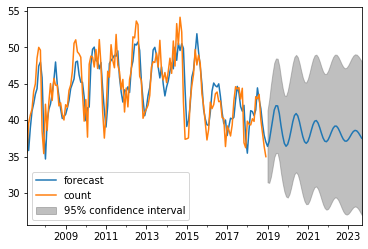

In [170]:
model = ARIMA(example_sample, order=(8,1,1))
results = model.fit(disp=0)

results.plot_predict(1,200);
results.summary()

In [171]:
X = example_sample.values
size = int(len(X) * 0.75)   # Split percentage

train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

for t in tqdm(range(len(test))):
    model = ARIMA(history, order=(8,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)


100%|██████████| 36/36 [01:03<00:00,  1.76s/it]


Test MAE: 1.734


4.34130454503768

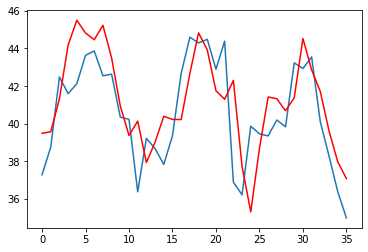

In [172]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red');

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(test, predictions)